# Linear Regression Using Reddit-scraping and Alpha Vantage Stock API

In this notebook, we will perform linear regression with the data that we scraped from Reddit, together with corresponding data from the Alpha Vantage API, which is one of the mandatory datasets that we have to use for this project.

### Essential Libraries
```
> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  
> time : To pace the number of API calls made to AlphaVantage
> AlphaVantage : To make API calls to retrieve data
```

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import time
sb.set() # set the default Seaborn style for graphics
from alpha_vantage.timeseries import TimeSeries
API_KEY = 'ZLL997KKZMX2B4BL'
app = TimeSeries(API_KEY, output_format='pandas')

### Loading the Reddit Data

In [2]:
redditData = pd.read_csv('scrappedData.csv')
redditData.head()
redditData = redditData.set_index('date')
redditData.columns += ' Comments'
redditData.head()
redditData.index.dtype

dtype('O')

In [3]:
print("Data type : ", type(redditData))
print("Data dims : ", redditData.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (695, 9)


Check the variables (and their types) in the dataset using the `dtypes` attribute.

In [4]:
print(redditData.dtypes)

Apple Reddit Posts                int64
Microsoft Reddit Posts            int64
Costco Reddit Posts               int64
Tesla Reddit Posts                int64
Nio Reddit Posts                  int64
Gamestop Reddit Posts             int64
AMC Reddit Posts                  int64
Tilray Reddit Posts               int64
Bed Bath & Beyond Reddit Posts    int64
dtype: object


### Alpha Vantage API Calls

API calls to get daily adjusted stock prices and trade volumes. The Alpha Vantage API only allows 5 calls per minute, so you have to be careful when using it, otherwise you'll run into exceptions.

In [6]:
AAPL = app.get_daily_adjusted('AAPL', outputsize='full')[0][:721]
MSFT = app.get_daily_adjusted('MSFT', outputsize='full')[0][:721]
COST = app.get_daily_adjusted('COST', outputsize='full')[0][:721]
TSLA = app.get_daily_adjusted('TSLA', outputsize='full')[0][:721]
NIO = app.get_daily_adjusted('NIO', outputsize='full')[0][:721]
time.sleep(60)  # AV only allows 5 calls per minute
GME = app.get_daily_adjusted('GME', outputsize='full')[0][:721]
AMC = app.get_daily_adjusted('AMC', outputsize='full')[0][:721]
# SPCE = app.get_daily_adjusted('SPCE', outputsize='full')[0][:721]
TLRY = app.get_daily_adjusted('TLRY', outputsize='full')[0][:721]
BBBY = app.get_daily_adjusted('BBBY', outputsize='full')[0][:721]

### Overview of Alpha Vantage Data

Here are a few rows of the data obtained from Alpha Vantage for the stock TSLA. A variety of information has been obtained, and the main one we'll be using is "6.volume".

In [138]:
TSLA.head()

1. open   2. high   3. low  4. close  5. adjusted close  \
date                                                                  
2021-04-14   770.70  780.7900  728.030    732.23             732.23   
2021-04-13   712.70  763.0000  710.660    762.32             762.32   
2021-04-12   685.70  704.8000  682.090    701.98             701.98   
2021-04-09   677.77  680.9700  669.430    677.02             677.02   
2021-04-08   677.38  689.5499  671.645    683.80             683.80   

             6. volume  7. dividend amount  8. split coefficient  
date                                                              
2021-04-14  48498095.0                 0.0                   1.0  
2021-04-13  44652808.0                 0.0                   1.0  
2021-04-12  29135670.0                 0.0                   1.0  
2021-04-09  21437087.0                 0.0                   1.0  
2021-04-08  23924329.0                 0.0                   1.0

In [83]:
pd.set_option('display.max_rows', None)

### No. of Reddit Comments vs Trade Volume

As we hypothesised earlier, more comments about a particular stock = more people buying and selling that stock. As such, we'll check the **correlation** between **No. of Reddit Comments** and **Trade Volume**, for each of the 10 stocks that we chose, except for the stock SPCE. It turns out that SPCE is so unpopular on Reddit that there were hardly any comments on it. There were too many zeroes and the data was unsusable, so we'll just make do with the remaining 9 stocks. 

In [7]:
# allCompanies = [AAPL, MSFT, COST, TSLA, NIO, GME, AMC, SPCE, TLRY, BBBY]
allCompanies = [AAPL, MSFT, COST, TSLA, NIO, GME, AMC, TLRY, BBBY]
joinedFrames = []
for i in range(9):
    y = allCompanies[i].iloc[::-1]
    y = pd.DataFrame(y['6. volume'])
    y = y.rename(columns={'6. volume':'Trade Volume'})
    y.index = y.index.astype(str)
    x = redditData.iloc[:, i]
    jointDF = pd.concat([x,y], axis = 1).reindex(y.index)
    jointDF = jointDF.dropna()
    joinedFrames.append(jointDF)
    # f = plt.figure(figsize=(6, 6))
    # sb.heatmap(jointDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")
    print(jointDF.corr())

                Apple Comments  Trade Volume
Apple Comments        1.000000      0.550165
Trade Volume          0.550165      1.000000
                    Microsoft Comments  Trade Volume
Microsoft Comments             1.00000       0.23268
Trade Volume                   0.23268       1.00000
                 Costco Comments  Trade Volume
Costco Comments         1.000000      0.348574
Trade Volume            0.348574      1.000000
                Tesla Comments  Trade Volume
Tesla Comments        1.000000      0.644495
Trade Volume          0.644495      1.000000
              Nio Comments  Trade Volume
Nio Comments      1.000000      0.711537
Trade Volume      0.711537      1.000000
                   Gamestop Comments  Trade Volume
Gamestop Comments           1.000000      0.661897
Trade Volume                0.661897      1.000000
              AMC Comments  Trade Volume
AMC Comments      1.000000      0.575442
Trade Volume      0.575442      1.000000
                 Tilray Comment

### Correlation

As you can see, we actually got some promising correlation figures from stocks like Tesla, Gamestop, and Nio. Some of the others weren't so good, such as Microsoft and Tilray. Usually, we wouldn't bother doing linear regression for the stocks with poor correlation, but we'll just do everything since have time :)

---

## Uni-Variate Linear Regression (AAPL)


In [10]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Reversing the order to ascending dates, resetting the index so the data can be concatenated. 
Also renaming the x axis and dividing the volume values by 100k so that numbers are not so large.


In [11]:
x = joinedFrames[0]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

### Train and Test Datasets

Train Set with 503 samples

Test Set with 168 samples

In [12]:
# # Train Set : 60 samples
# volume_train = pd.DataFrame(volume[:60])
# post_train = pd.DataFrame(post[:60])

# # Test Set : 27 samples
# volume_test = pd.DataFrame(volume[-27:])
# post_test = pd.DataFrame(post[-27:])


# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (503, 1) (503, 1)
Test Set  : (168, 1) (168, 1)


### Basic Exploration

Perform basic statistical exploration and visualization on the Train Set.

In [13]:
volume_train.describe()

Trade Volume(100k)
count          503.000000
mean           549.671915
std            454.176858
min            121.197140
25%            258.839320
50%            357.682370
75%            750.737700
max           3326.071630

In [14]:
post_train.describe()

Apple Comments
count      503.000000
mean       135.512922
std        229.128635
min          0.000000
25%         27.000000
50%         58.000000
75%        141.500000
max       2103.000000

<AxesSubplot:>

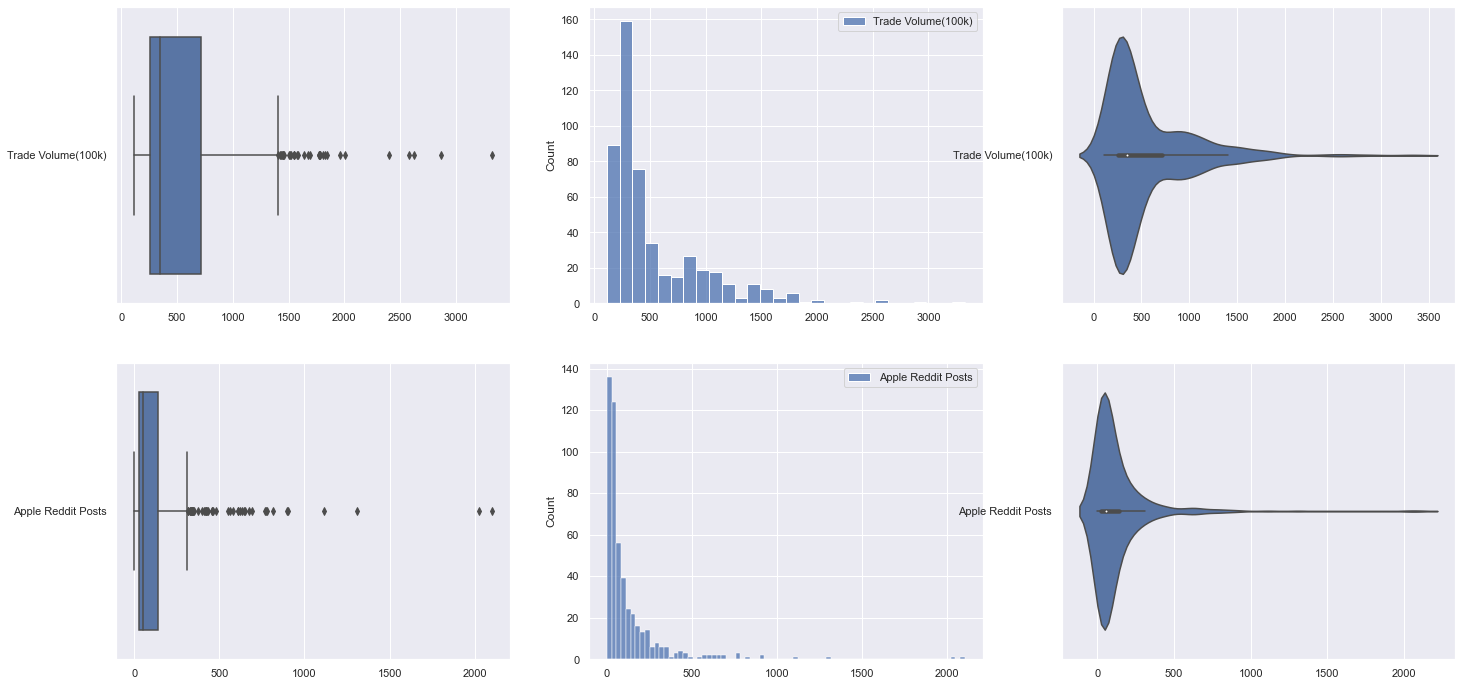

In [110]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

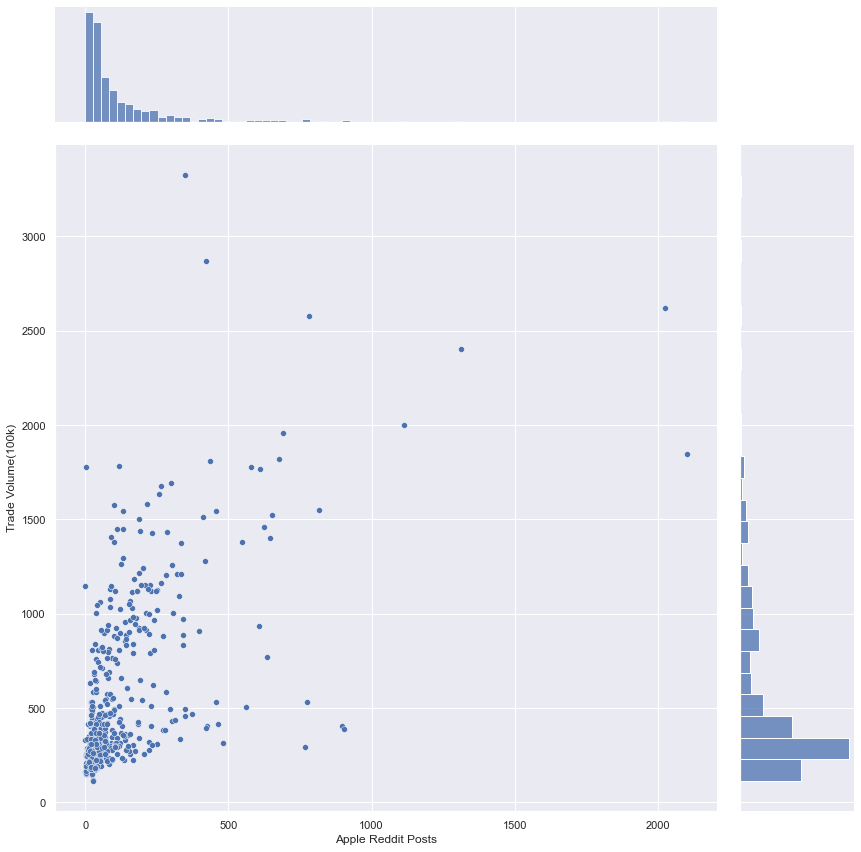

In [112]:
# Create a joint dataframe by concatenating the two variables
trainDF = pd.concat([volume_train, post_train], axis = 1).reindex(volume_train.index)

sb.jointplot(data = trainDF, x = "Apple Reddit Posts", y = "Trade Volume(100k)", height = 12)

<AxesSubplot:>

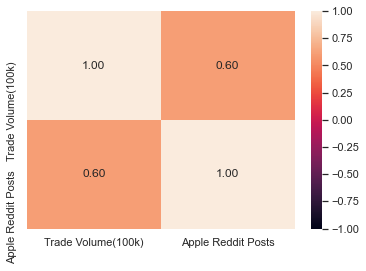

In [114]:
# Calculate the correlation between the two columns/variables
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

### Linear Regression using Scikit-Learn

Scikit-Learn (`sklearn`) will be our de-facto Machine Learning library in Python.   
Import the `LinearRegression` model from `sklearn.linear_model`.

In [115]:
# Create a Linear Regression object
linreg = LinearRegression()

Train the Linear Regression model `linreg` using the Train Set.   
Use `post_train` as *Predictor* and `volume_train` as *Response*.

In [116]:
# Train the Linear Regression model
linreg.fit(post_train, volume_train)

LinearRegression()

You have *trained* the model to fit the following formula.

>  Regression Problem : Total = $a$ $\times$ HP + $b$

Check Intercept ($a$) and Coefficient ($b$) of the regression line.

In [117]:
# Coefficients of the Linear Regression line
print('Intercept \t: b = ', linreg.intercept_)
print('Coefficients \t: a = ', linreg.coef_)

Intercept 	: b =  [376.53843739]
Coefficients 	: a =  [[1.3441399]]


Plot the regression line based on the coefficients-intercept form.

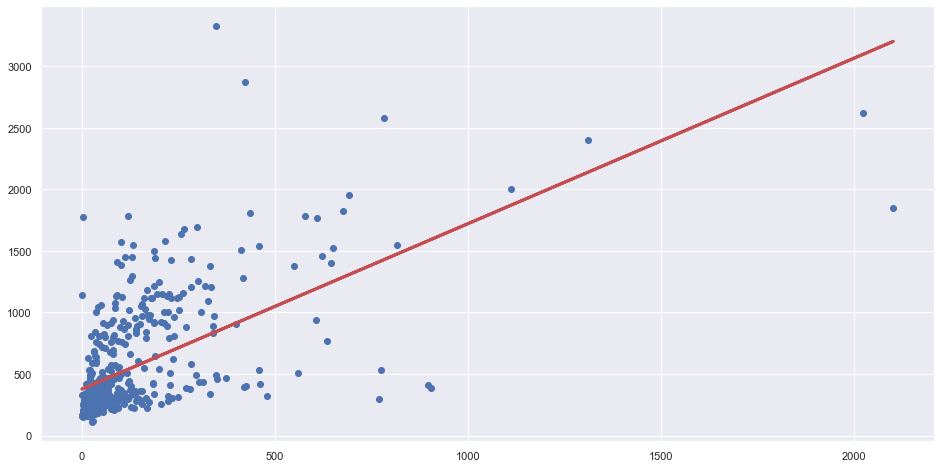

In [118]:
# Formula for the Regression line
regline_x = post_train
regline_y = linreg.intercept_ + linreg.coef_ * post_train

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

Plot the regression line by prediction using the model.

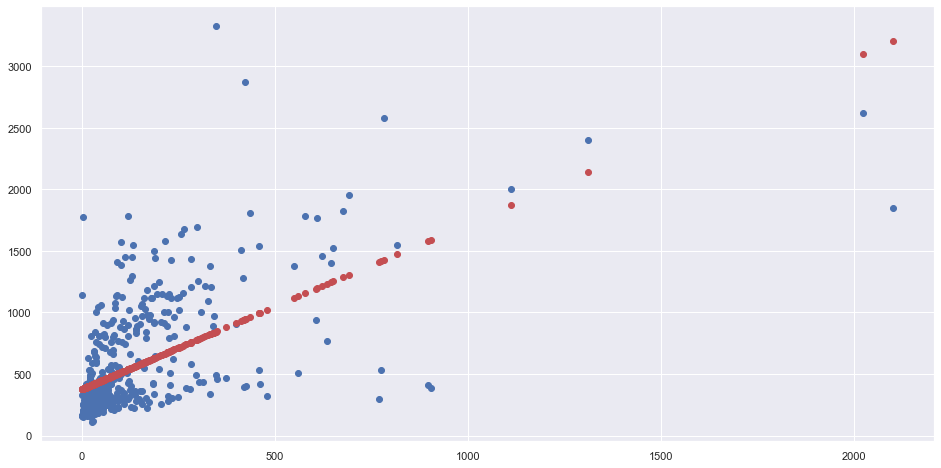

In [119]:
# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

#### Goodness of Fit of the Model

Check how good the predictions are on the Train Set.    
Metrics : Explained Variance and Mean Squared Error.

In [120]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))


mse = mean_sq_err(volume_train, volume_train_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Explained Variance (R^2) 	: 0.3620583213448586
Mean Squared Error (MSE) 	: 130554.1117517211
Root Mean Squared Error (RMSE) 	: 361.32272520797954


Test the Linear Regression model `linreg` using the Test Set.   

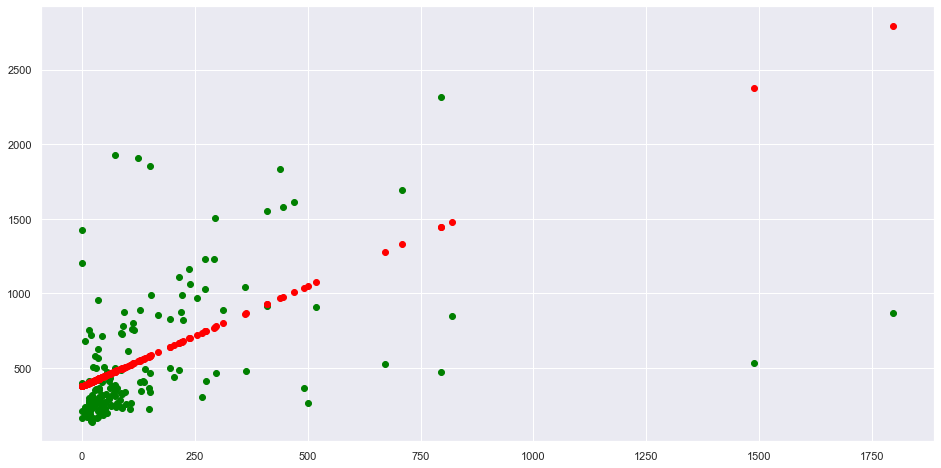

In [121]:
# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

Check how good the predictions are on the Test Set.    
Metrics : Explained Variance and Mean Squared Error.

In [122]:
# Explained Variance (R^2)
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))

# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

mse = mean_sq_err(volume_test, volume_test_pred)
print("Mean Squared Error (MSE) \t:", mse)
print("Root Mean Squared Error (RMSE) \t:", np.sqrt(mse))

Explained Variance (R^2) 	: 0.059351947126772275
Mean Squared Error (MSE) 	: 164093.739941157
Root Mean Squared Error (RMSE) 	: 405.0848552354889


### Conclusion for AAPL

Pretty poor performance on the test set as the R^2 value is very low.

---

## Uni-Variate Linear Regression (MSFT)

For the rest of the stocks, we'll just be repeating the linear regression steps, so I won't be writing any additional comments.

In [123]:
x = joinedFrames[1]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (503, 1) (503, 1)
Test Set  : (168, 1) (168, 1)


<AxesSubplot:>

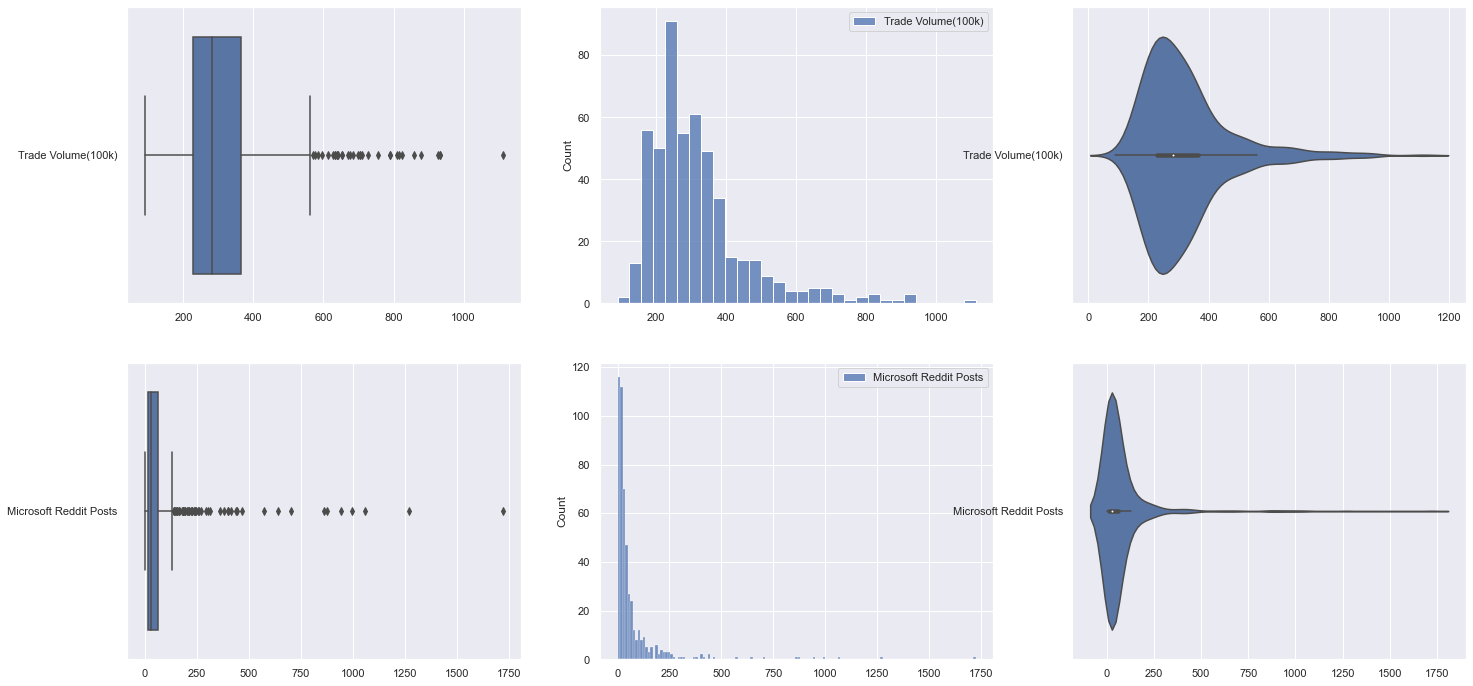

In [124]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [302.20645367]
Coefficients of Regression 	: a =  [[0.22601064]]



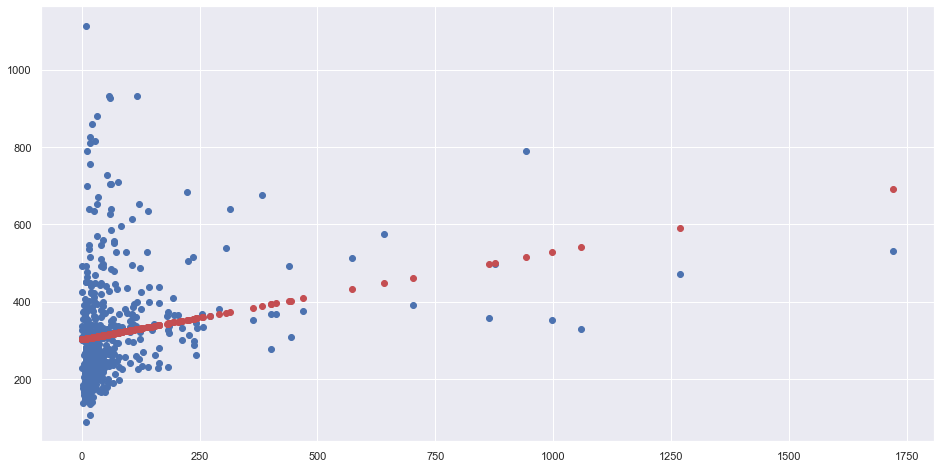

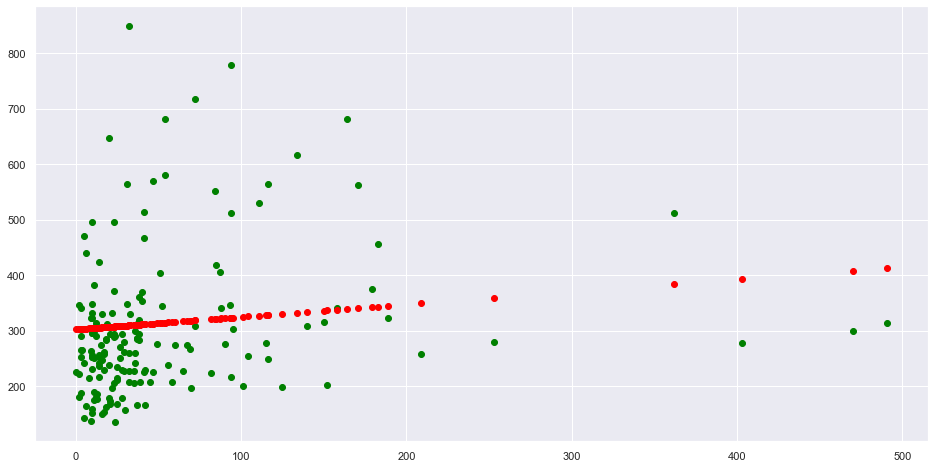

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.056699165830632725
Mean Squared Error (MSE) 	: 19839.776778976087

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.031962943806838284
Mean Squared Error (MSE) 	: 16272.654836967105



In [125]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for MSFT

Pretty poor performance on the test set as the R^2 value is very low.

---

## Uni-Variate Linear Regression (COST)

In [127]:
x = joinedFrames[2]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (503, 1) (503, 1)
Test Set  : (168, 1) (168, 1)


<AxesSubplot:>

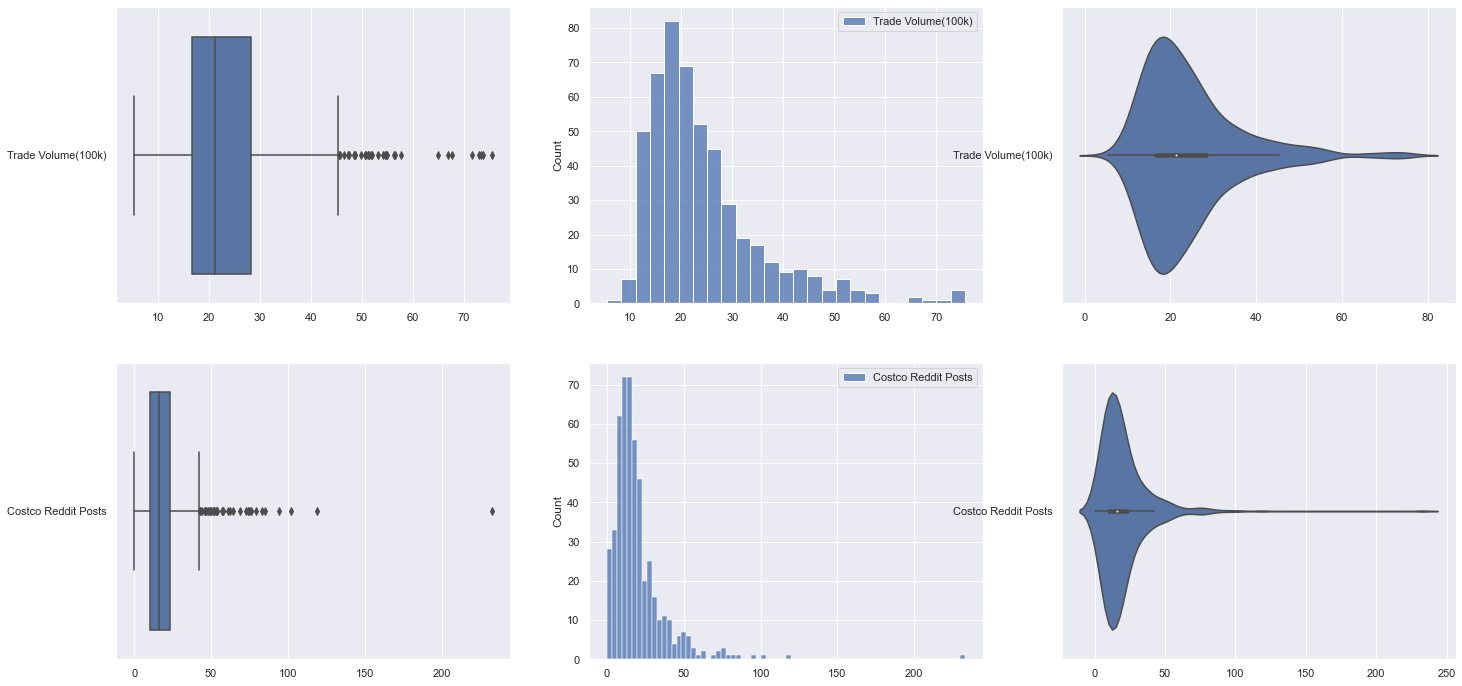

In [128]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [20.30456071]
Coefficients of Regression 	: a =  [[0.20437371]]



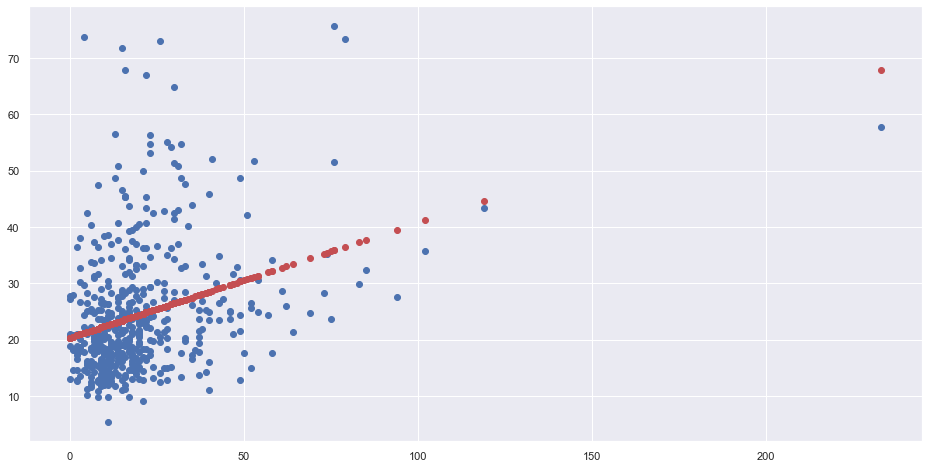

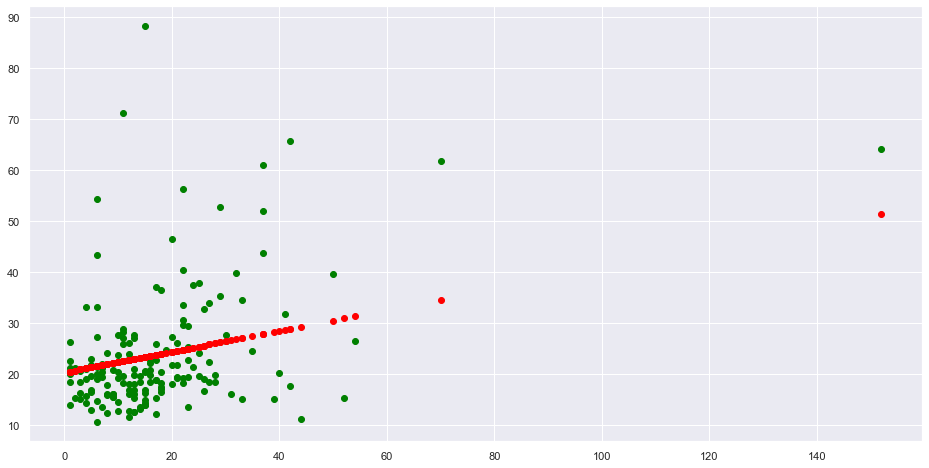

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.1090597373132225
Mean Squared Error (MSE) 	: 116.52985150173618

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.1481390053709184
Mean Squared Error (MSE) 	: 128.48779877781877



In [129]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for COST

Pretty poor performance on the test set as the R^2 value is very low, althought it is higher than the previous 2. 

---

## Uni-Variate Linear Regression (TSLA)

In [130]:
x = joinedFrames[3]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (503, 1) (503, 1)
Test Set  : (168, 1) (168, 1)


<AxesSubplot:>

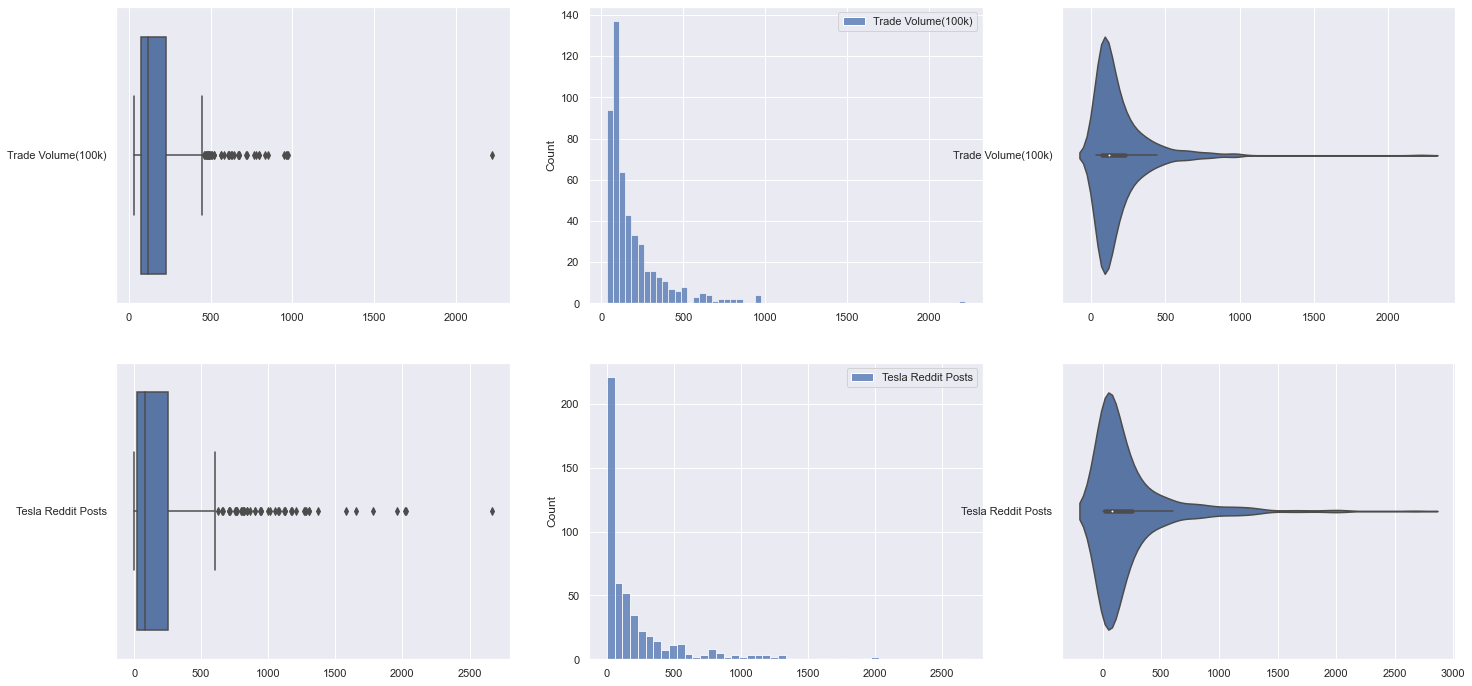

In [131]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [113.39423918]
Coefficients of Regression 	: a =  [[0.34116866]]



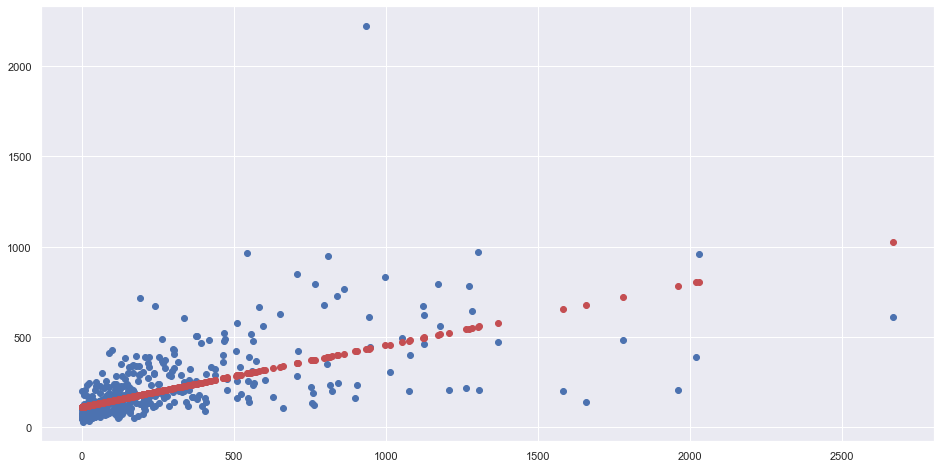

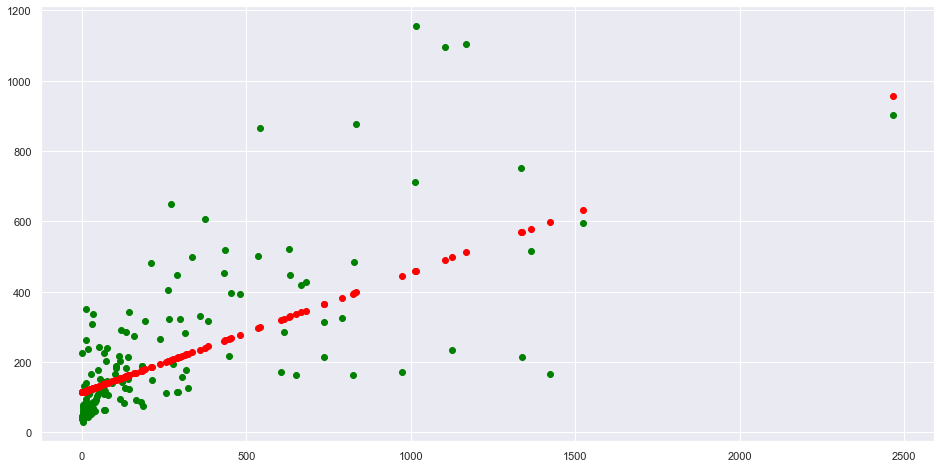

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.38091685488378835
Mean Squared Error (MSE) 	: 22346.4921314019

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.48739037075327607
Mean Squared Error (MSE) 	: 23556.350140554066



In [132]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for TSLA

Much better performance on the test dataset! Highest R^2 so far. 

---

## Uni-Variate Linear Regression (NIO)

In [63]:
x = joinedFrames[4]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (473, 1) (473, 1)
Test Set  : (158, 1) (158, 1)


<AxesSubplot:>

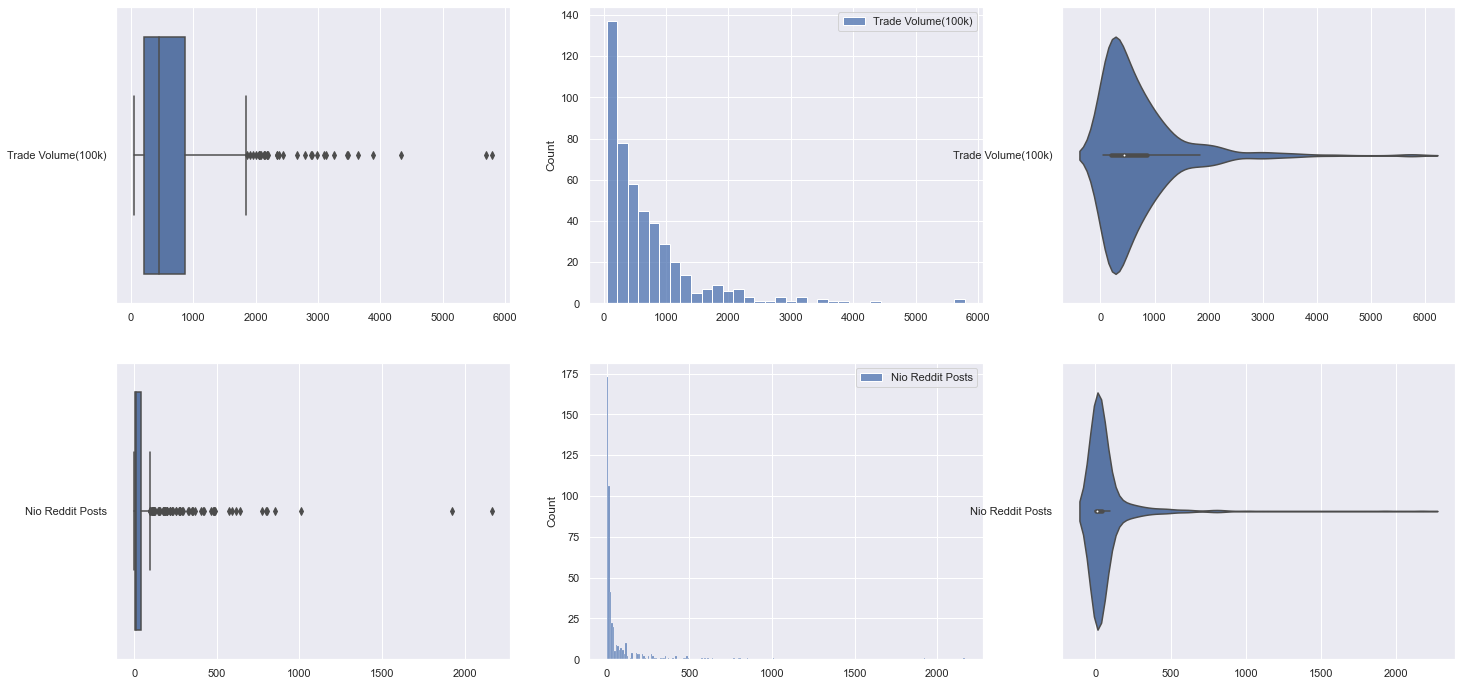

In [64]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [494.23060315]
Coefficients of Regression 	: a =  [[2.84109364]]



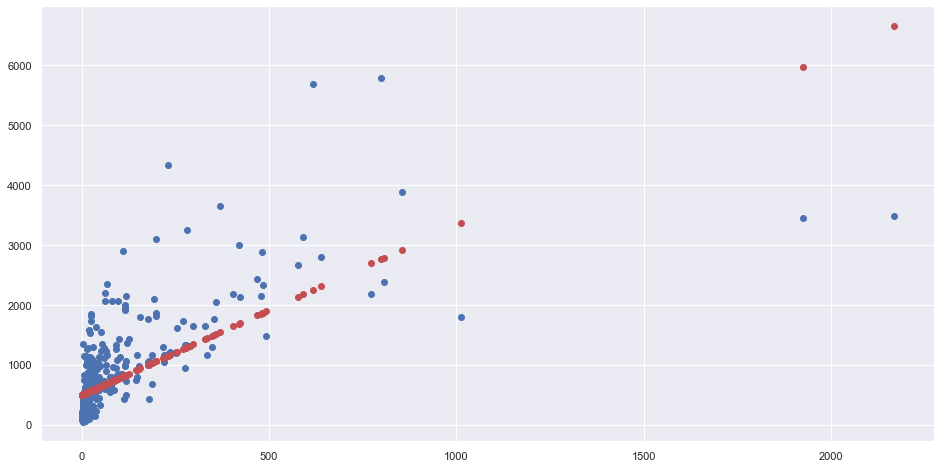

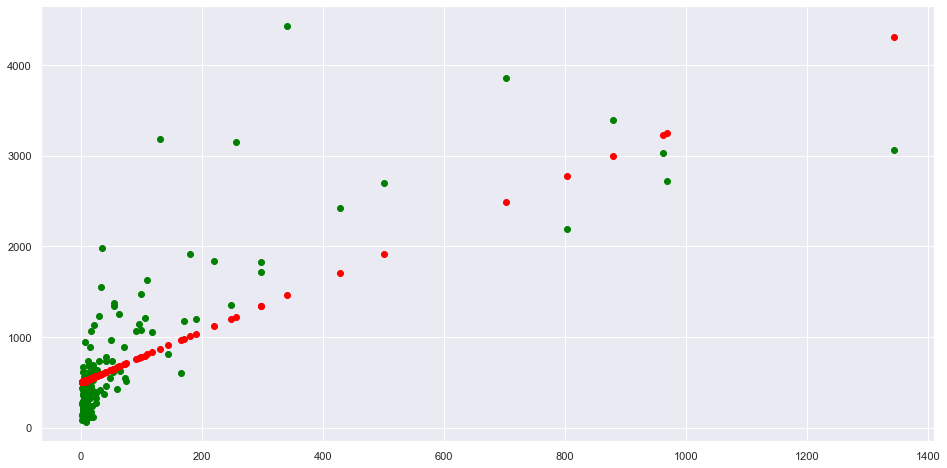

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.47226893539827375
Mean Squared Error (MSE) 	: 298653.8584195171

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.596793954952715
Mean Squared Error (MSE) 	: 251340.00154617883



In [65]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for NIO

Pretty high R^2 on the test dataset, even higher than TSLA. This is expected as NIO had the highest correlation when we did exploratory analysis.

---

## Uni-Variate Linear Regression (GME)

In [66]:
x = joinedFrames[5]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (495, 1) (495, 1)
Test Set  : (165, 1) (165, 1)


<AxesSubplot:>

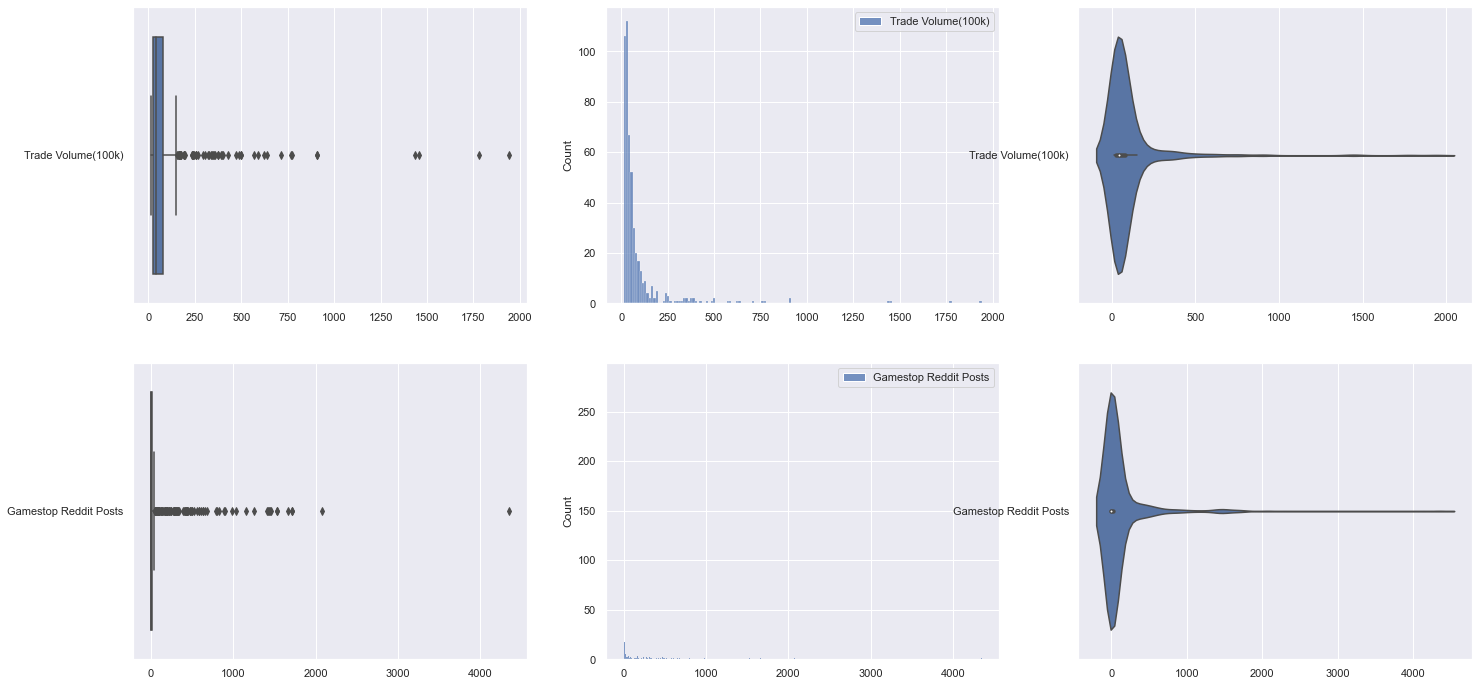

In [67]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [53.06316388]
Coefficients of Regression 	: a =  [[0.36905543]]



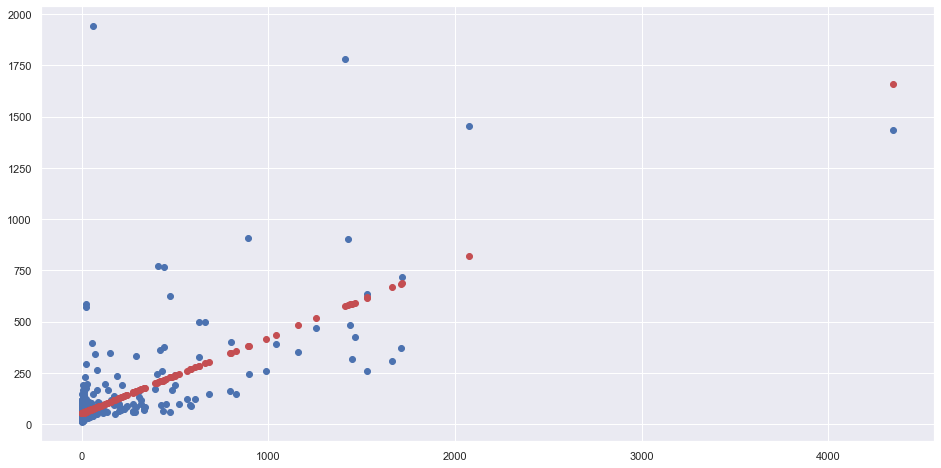

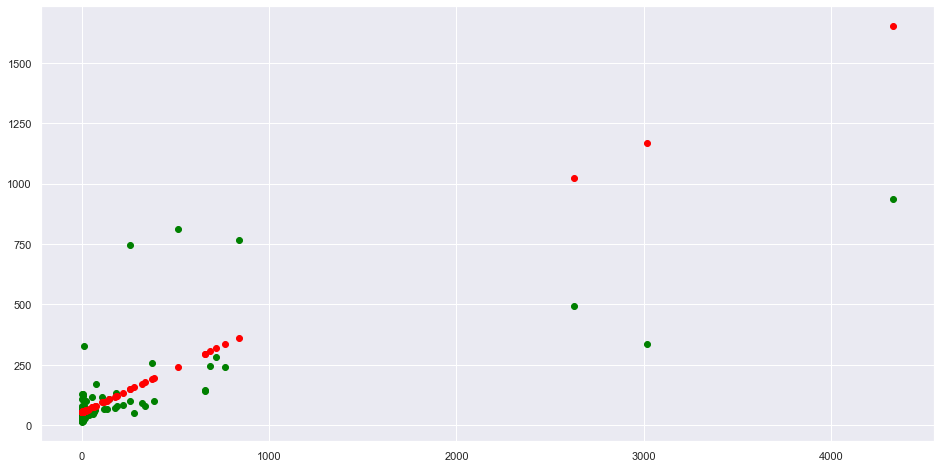

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.4677450704615199
Mean Squared Error (MSE) 	: 18145.314198982844

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.1062022250539627
Mean Squared Error (MSE) 	: 15874.28641889074



In [68]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for GME

The linear model doesn't perform well on the test dataset, despite the high correlation value for GME.

---

## Uni-Variate Linear Regression (AMC)

In [69]:
x = joinedFrames[6]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (495, 1) (495, 1)
Test Set  : (165, 1) (165, 1)


<AxesSubplot:>

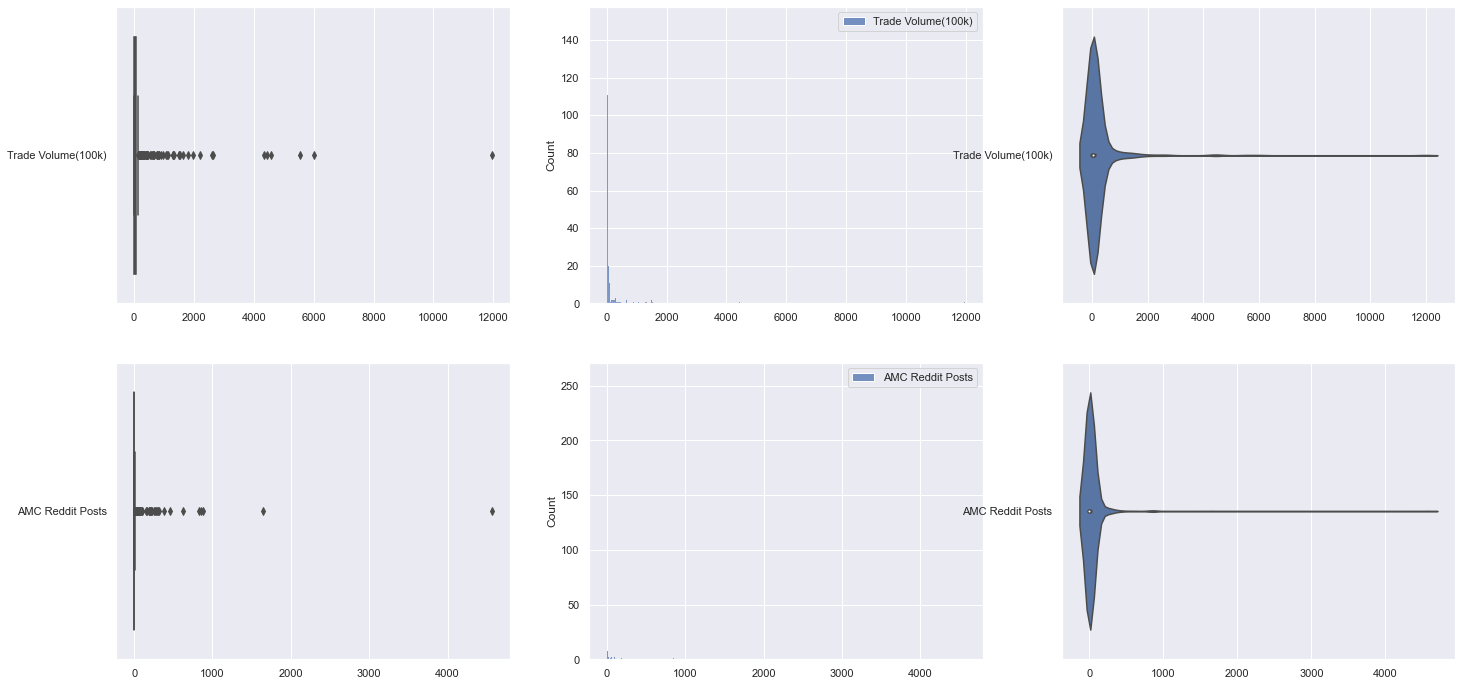

In [70]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [145.55814413]
Coefficients of Regression 	: a =  [[1.70524415]]



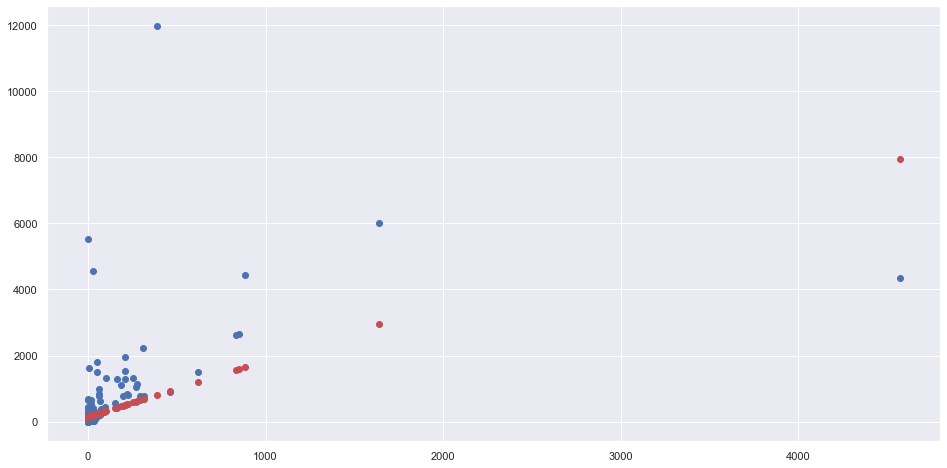

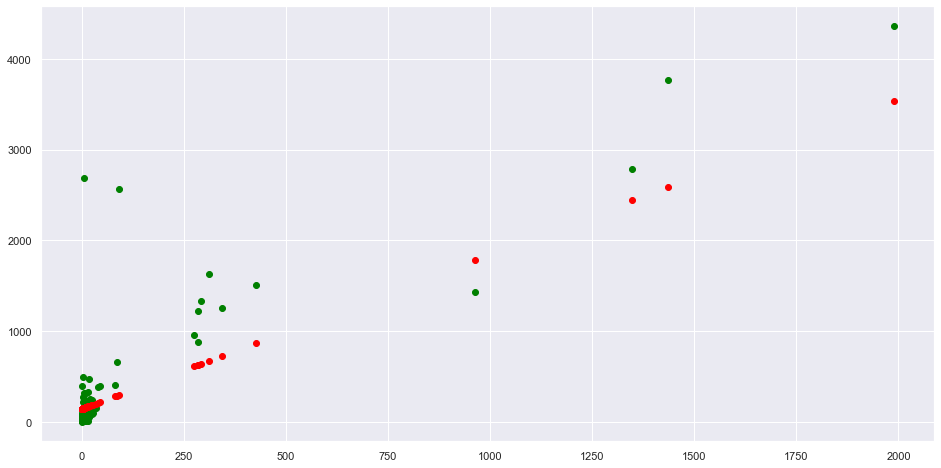

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.25403152218077174
Mean Squared Error (MSE) 	: 464412.5064814938

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6982354913914186
Mean Squared Error (MSE) 	: 114084.86118584103



In [71]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for AMC

AMC had one of the higher correlation values, and the R^2 on the test dataset is the highest so far! AMC is an interesting case, as it is one of the meme stocks that rose to fame on Reddit. If you look at the data points, there are many points near the origin. It seems as though nobody was trading AMC's stock until it blew up on reddit. 

---

## Uni-Variate Linear Regression (TLRY)

In [72]:
x = joinedFrames[7]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (493, 1) (493, 1)
Test Set  : (165, 1) (165, 1)


<AxesSubplot:>

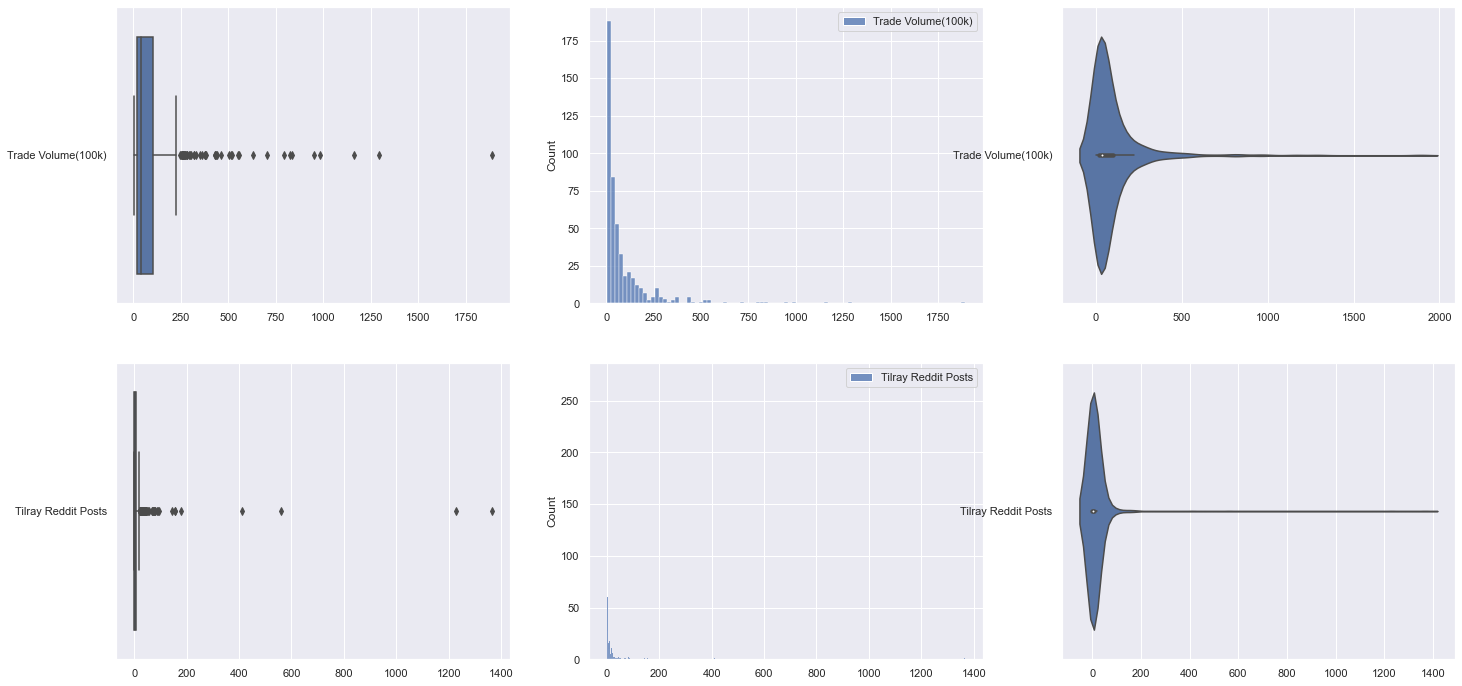

In [73]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [86.20358558]
Coefficients of Regression 	: a =  [[0.5319083]]



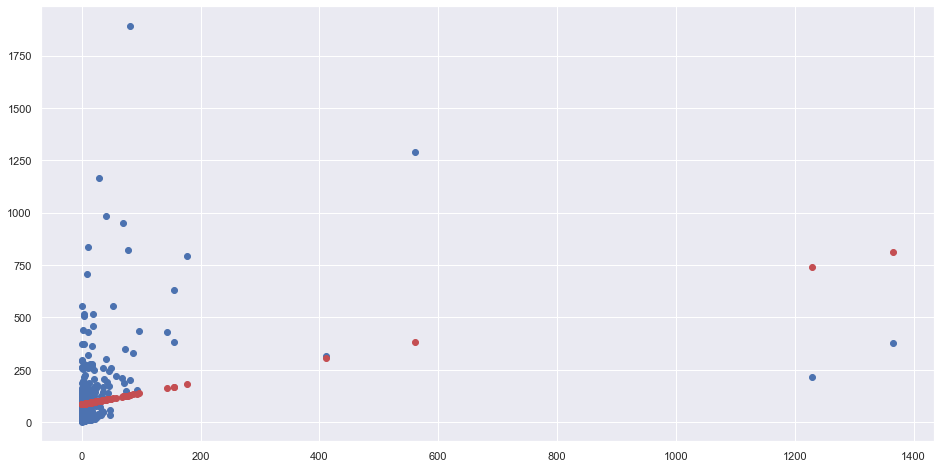

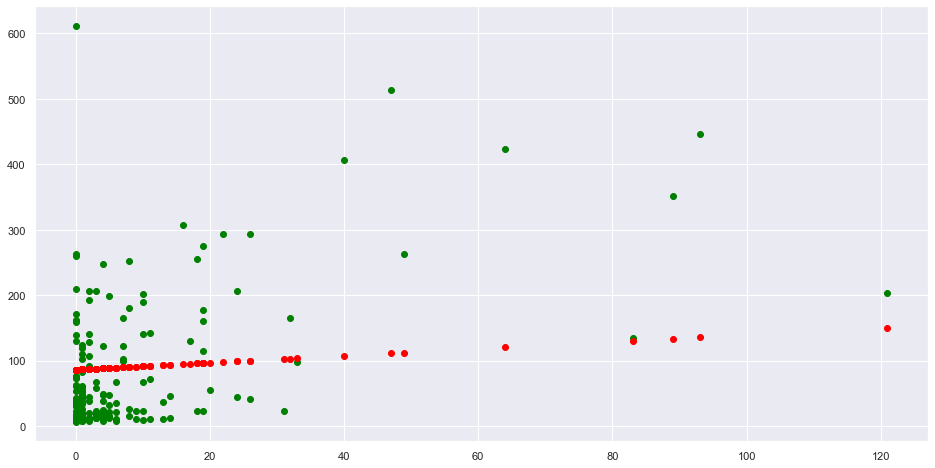

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.07898420137396578
Mean Squared Error (MSE) 	: 26545.316924383813

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.07935912444298832
Mean Squared Error (MSE) 	: 10195.249344437128



In [74]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for TLRY

Pretty poor performance on the test set as the R^2 value is very low.

---

## Uni-Variate Linear Regression (BBBY)

In [133]:
x = joinedFrames[8]
x = x.rename(columns={'Trade Volume':'Trade Volume(100k)'})
volume = pd.DataFrame(x.iloc[:, 1]/100000)  # Response
post = pd.DataFrame(x.iloc[:, 0])     # Predictor

# Randomly split the Dataset into Train and Test
post_train, post_test, volume_train, volume_test = train_test_split(post, volume, test_size = 0.25)

# Check the sample sizes
print("Train Set :", volume_train.shape, post_train.shape)
print("Test Set  :", volume_test.shape, post_test.shape)

Train Set : (503, 1) (503, 1)
Test Set  : (168, 1) (168, 1)


<AxesSubplot:>

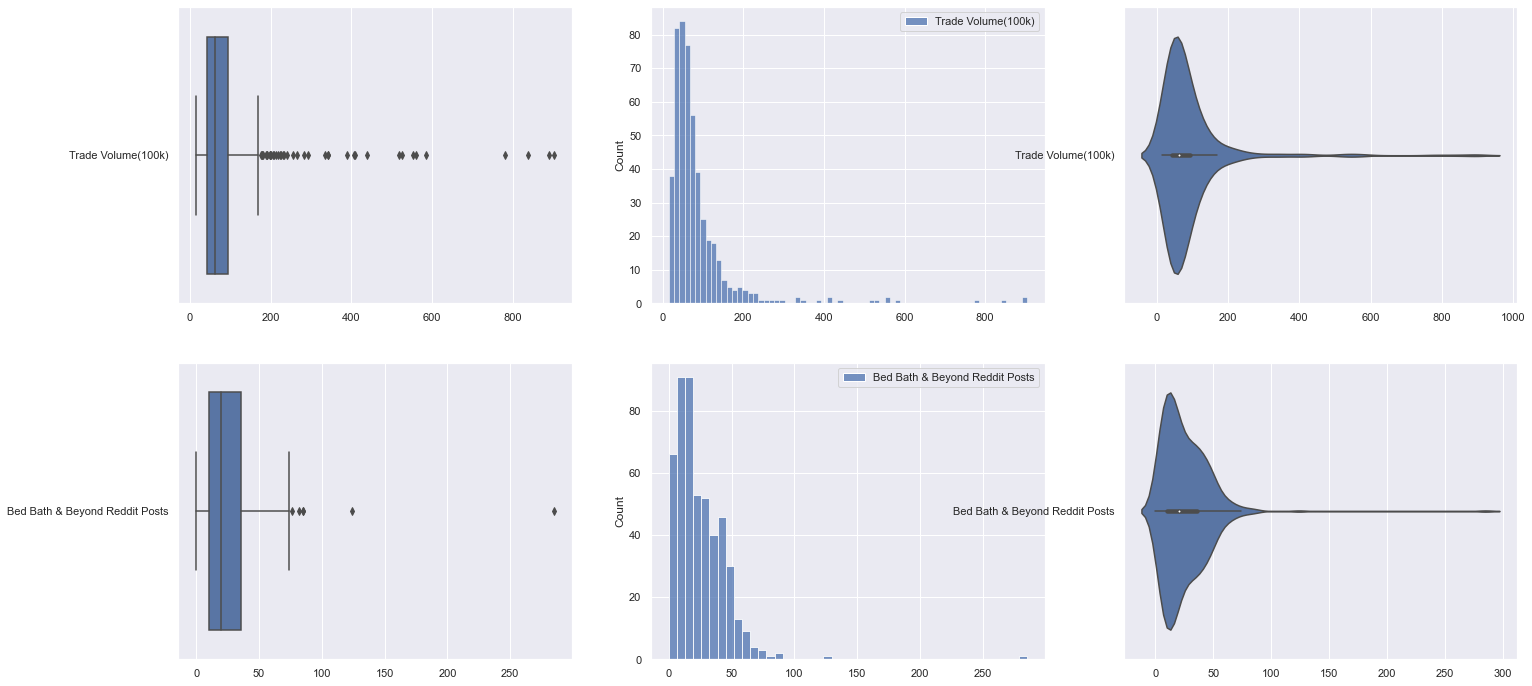

In [134]:
# Set up matplotlib figure with three subplots
f, axes = plt.subplots(2, 3, figsize=(24, 12))

# Plot the basic uni-variate figures for HP Train
sb.boxplot(data = volume_train, orient = "h", ax = axes[0,0])
sb.histplot(data = volume_train, ax = axes[0,1])
sb.violinplot(data = volume_train, orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for Total Train
sb.boxplot(data = post_train, orient = "h", ax = axes[1,0])
sb.histplot(data = post_train, ax = axes[1,1])
sb.violinplot(data = post_train, orient = "h", ax = axes[1,2])

Intercept of Regression 	: b =  [39.83428964]
Coefficients of Regression 	: a =  [[1.97316666]]



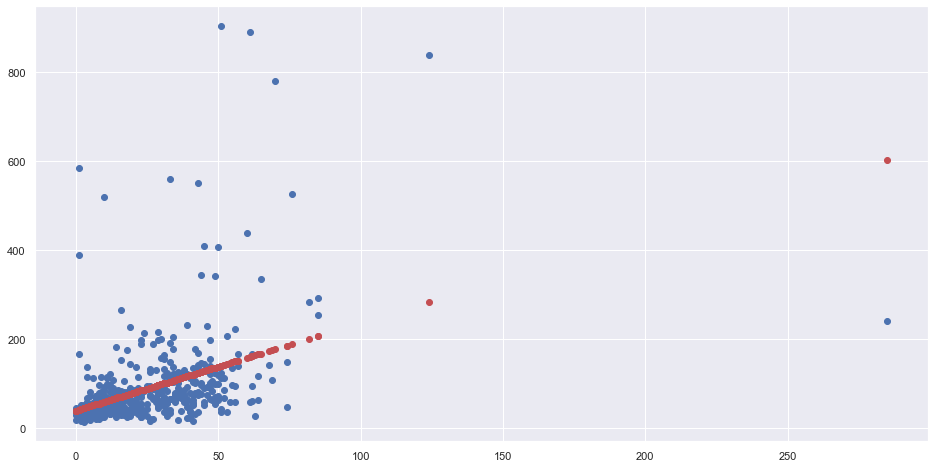

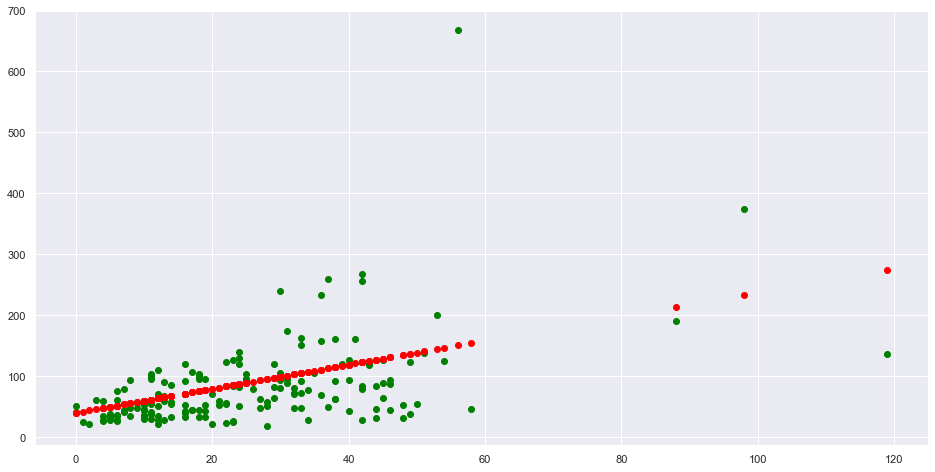

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.16808510639778051
Mean Squared Error (MSE) 	: 8549.045400450697

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.2300204977870851
Mean Squared Error (MSE) 	: 3805.4933239614434



In [135]:
linreg = LinearRegression()         # create the linear regression object
linreg.fit(post_train, volume_train)        # train the linear regression model

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict Volume values corresponding to post Train
volume_train_pred = linreg.predict(post_train)

# Plot the Linear Regression line
f = plt.figure(figsize=(16, 8))
plt.scatter(post_train, volume_train)
plt.scatter(post_train, volume_train_pred, color = "r")
plt.show()

# Predict Total values corresponding to HP Test
volume_test_pred = linreg.predict(post_test)

# Plot the Predictions
f = plt.figure(figsize=(16, 8))
plt.scatter(post_test, volume_test, color = "green")
plt.scatter(post_test, volume_test_pred, color = "red")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_train, volume_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_train, volume_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(post_test, volume_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(volume_test, volume_test_pred))
print()

### Conclusion for BBBY

Pretty poor performance on the test set as the R^2 value is very low, but not the worst. 

## Final Thoughts About Uni-Variate Linear Regression

The linear model fitted well on the stocks with higher correlation values, with the exception of GME. Might be because the GME situation is more complex than the other stocks, with many more factors in play. The linear regression model performed well on three stocks: AMC, NIO, and TSLA.

### What does this mean?

As a retail investor, I can potentially use the number of comments on r/WallStreetBets about NIO, AMC, and TSLA, to predict the trade volume for each of these 3 stocks. If the predicted trade volume is high, this means that there is potential for me to make larger short term gains, and I should consider buying these stocks. Nonetheless, with a higher trade volume, there is greater risk involved, as the stock price could plummet as well. So, after predicting the trade volume for these 3 stocks, is there a way for us to predict their stock prices? Although predicting trade volume is useful, the ultimate goal would be to successfully predict stock price, and get rich :)

---

## Multi-Variate Linear Regression to Predict Price

Moving on, we will do Multi-Variate Linear Regression on NIO. We chose NIO because it had the second highest R^2 value on the test dataset. Although AMC had the best performance, its trade volumes and prices are all over the place because it's a meme stock.  

Response Variable : **Closing Price** 

Predictor Feature : **Volume, No.of Reddit Comments**

Let's see if we can use the number of Reddit comments about NIO and its trade volume to predict its price.

Extract the variables and the associated data as a Pandas `DataFrame`.

In [18]:
# TAs
from alpha_vantage.techindicators import TechIndicators

app = TechIndicators(API_KEY, output_format='pandas')
#help(app.get_macd)

interval = 'daily'
periods = 14

# SMA
# AAPL_sma = app.get_sma('AAPL', interval = interval, time_period=periods, series_type='close')[0][:500]
# MSFT_sma = app.get_sma('MSFT', interval = interval, time_period=periods, series_type='close')[0][:500]
# COST_sma = app.get_sma('COST', interval = interval, time_period=periods, series_type='close')[0][:500]
# TSLA_sma = app.get_sma('TSLA', interval = interval, time_period=periods, series_type='close')[0][:500]
NIO_sma = app.get_sma('NIO', interval = interval, time_period=periods, series_type='close')[0][:]
# time.sleep(60)
# GME_sma = app.get_sma('GME', interval = interval, time_period=periods, series_type='close')[0][:500]
# AMC_sma = app.get_sma('AMC', interval = interval, time_period=periods, series_type='close')[0][1110:]
# SCPE_sma = app.get_sma('SPCE', interval = interval, time_period=periods, series_type='close')[0][:500]
# TLRY_sma = app.get_sma('TLRY', interval = interval, time_period=periods, series_type='close')[0][:500]
# BBBY_sma = app.get_sma('BBBY', interval = interval, time_period=periods, series_type='close')[0][:500]


In [92]:
NIO_sma.head()

SMA
date              
2018-10-01  8.1207
2018-10-02  8.0729
2018-10-03  7.6943
2018-10-04  7.4336
2018-10-05  7.2736

In [77]:
NIO.head()

1. open  2. high  3. low  4. close  5. adjusted close  \
date                                                                
2021-04-16    34.69   36.540   34.06     36.09              36.09   
2021-04-15    37.02   37.059   34.56     35.66              35.66   
2021-04-14    39.23   39.330   36.79     37.02              37.02   
2021-04-13    37.48   38.660   37.33     38.48              38.48   
2021-04-12    37.96   38.000   36.76     37.14              37.14   

              6. volume  7. dividend amount  8. split coefficient  
date                                                               
2021-04-16   84477372.0                 0.0                   1.0  
2021-04-15  100437437.0                 0.0                   1.0  
2021-04-14   78453961.0                 0.0                   1.0  
2021-04-13   62005707.0                 0.0                   1.0  
2021-04-12   53428087.0                 0.0                   1.0

In [15]:
redditData.head()

Apple Comments  Microsoft Comments  Costco Comments  \
date                                                              
2018-06-22              19                  45               14   
2018-06-29              39                  69               20   
2018-07-16               2                  11                1   
2018-07-17               1                   8                3   
2018-07-18               1                  10                3   

            Tesla Comments  Nio Comments  Gamestop Comments  AMC Comments  \
date                                                                        
2018-06-22              34             6                  3             2   
2018-06-29              28            23                  9             0   
2018-07-16               1             0                  0             0   
2018-07-17               1             0                  0             0   
2018-07-18               0             1                  0             0   

            Tilray Comments  Bed Bath & Beyond Comments  
date                                                     
2018-06-22                0                          14  
2018-06-29                8                          16  
2018-07-16                0                           2  
2018-07-17                0                           0  
2018-07-18                0                           0

In [20]:
# Extract Response and Predictors
newNIO = NIO.iloc[::-1]
newNIO.index = newNIO.index.astype(str)
# newSMA = NIO_sma
# newSMA.index = NIO_sma.index.astype(str)
# multiDF = pd.concat([newNIO['4. close'], newNIO['6. volume']/100000, newSMA['SMA'], redditData.iloc[:,4]], axis = 1).reindex(newSMA.index)
multiDF = pd.concat([newNIO['4. close'], newNIO['6. volume']/100000, redditData.iloc[:,4]], axis = 1).reindex(newNIO.index)
multiDF = multiDF.dropna()
multiDF = multiDF.rename(columns={'4. close':'Closing Price', '6. volume':'Trade Volume(100k)'})

y = pd.DataFrame(multiDF['Closing Price'])
X = pd.DataFrame(multiDF[["Trade Volume(100k)", "Nio Comments"]])

Set up the regression problem with Train and Test datasets.   

In [21]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (475, 1) (475, 2)
Test Set  : (159, 1) (159, 2)


### Basic Exploration

Perform basic statistical exploration and visualization on the Train Set.

In [81]:
# Summary Statistics for Response
y_train.describe()

Closing Price
count     329.000000
mean       16.938237
std        19.064998
min         1.320000
25%         3.020000
50%         4.270000
75%        28.480000
max        62.840000

In [22]:
# Summary Statistics for Predictors
X_train.describe()

Trade Volume(100k)  Nio Comments
count          475.000000    475.000000
mean           645.062662     58.930526
std            654.866585    154.213348
min             56.859640      0.000000
25%            215.100395      6.000000
50%            441.221490     12.000000
75%            830.362905     40.500000
max           5790.698700   2167.000000

<AxesSubplot:>

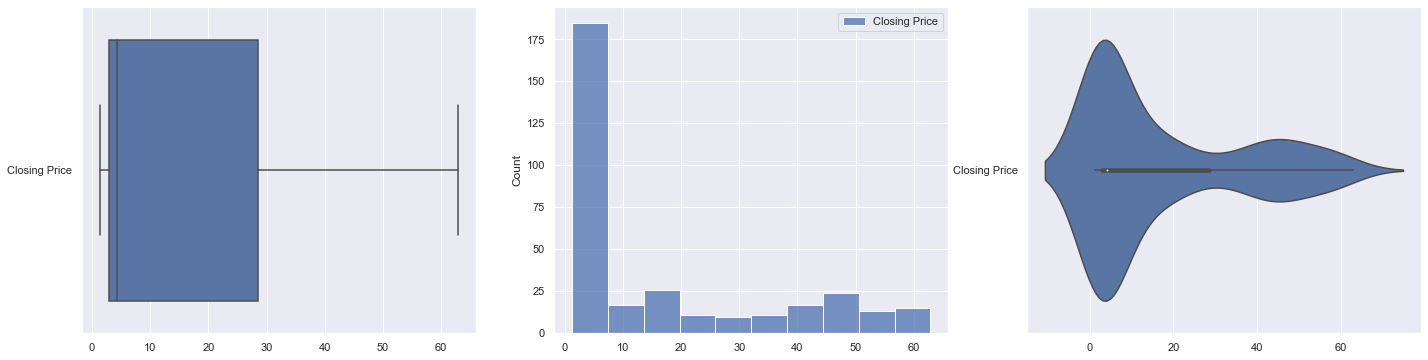

In [83]:
# Draw the distribution of Response
f, axes = plt.subplots(1, 3, figsize=(24, 6))
sb.boxplot(data = y_train, orient = "h", ax = axes[0])
sb.histplot(data = y_train, ax = axes[1])
sb.violinplot(data = y_train, orient = "h", ax = axes[2])

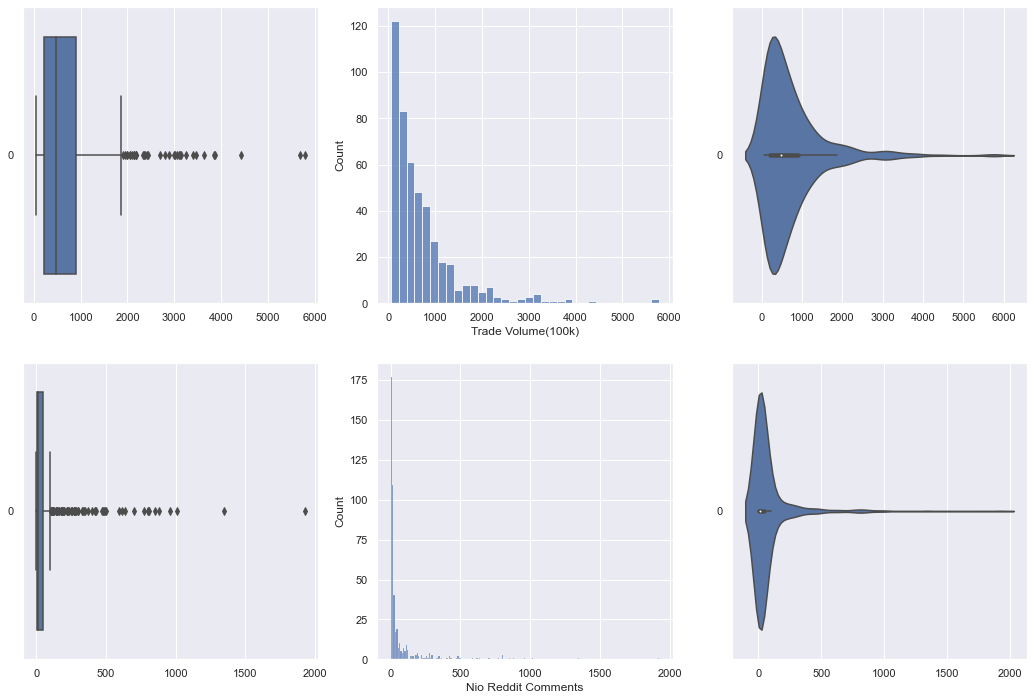

In [102]:
# Draw the distributions of all Predictors
f, axes = plt.subplots(2, 3, figsize=(18, 12))

count = 0
for var in X_train:
    sb.boxplot(data = X_train[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = X_train[var], ax = axes[count,1])
    sb.violinplot(data = X_train[var], orient = "h", ax = axes[count,2])
    count += 1

<AxesSubplot:>

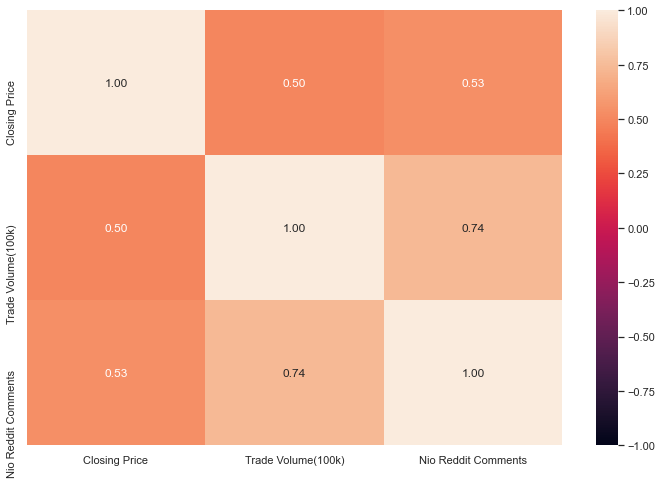

In [103]:
# Correlation between Response and the Predictors
trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

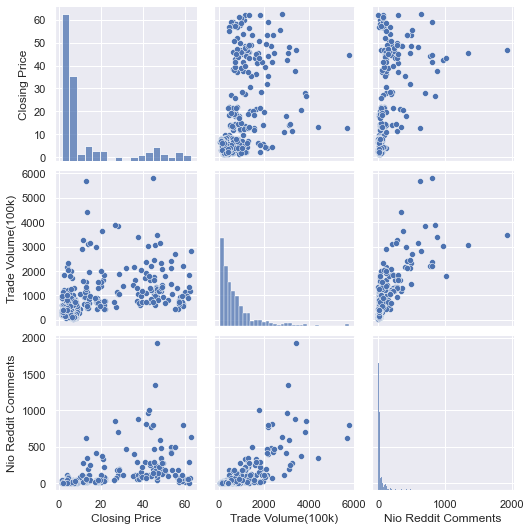

In [104]:
# Relationship between Response and the Predictors
sb.pairplot(data = trainDF)

#### Linear Regression using Scikit-Learn

In [105]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [7.95482311]
Coefficients of Regression 	: a =  [[0.00492035 0.03497042]]



Predictors  Coefficients
0   Trade Volume(100k)       0.00492
1  Nio Reddit Comments       0.03497

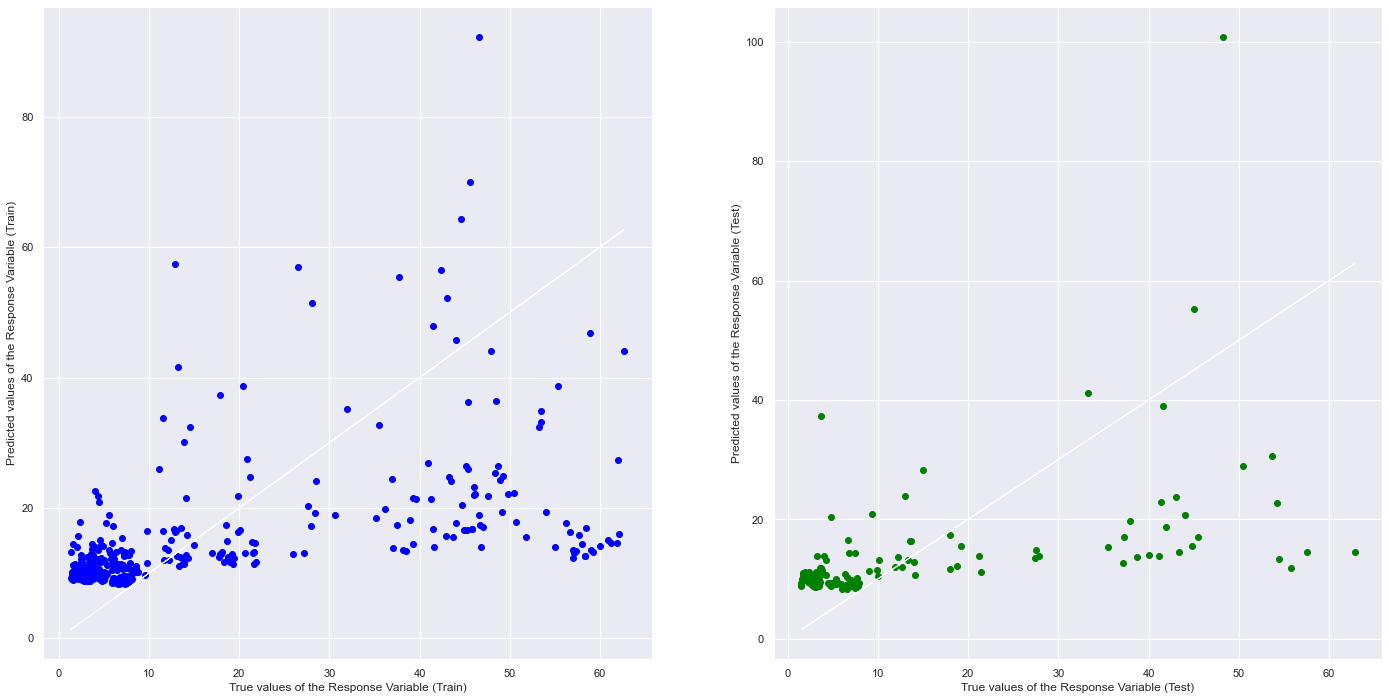

In [106]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

#### Goodness of Fit of the Model

In [107]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3087870403314604
Mean Squared Error (MSE) 	: 199.83606627683466

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.2546259169938654
Mean Squared Error (MSE) 	: 171.97035545375286



## Final Thoughts

The R^2 of the linear model is relatively low, and it seems like this multi-variate linear regression isn't able to successfully predict NIO's stock price. Moving on, let's see if there are other better methods that we can use to predict stock price. **Read our next notebook to find out more!**